## Maternal lineage 

PAN010 -> PAN027 -> PAN028

## Paternal lineage

PAN011 -> PAN027 -> PAN028

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybedtools

In [53]:
path_maternal="data/shared_contigs_maternal_coordinates.tsv"
path_paternal="data/shared_contigs_paternal_coordinates.tsv"

path_PAN028_index = "data/assembly.v1.0.PAN028.diploid-002.fa.fai"

path_grandmother_RM = "data/assembly.v1.0.PAN010.diploid.RM.bed"
path_grandfather_RM = "data/assembly.v1.0.PAN011.diploid.RM.bed"
path_mother_RM = "data/assembly.v1.0.PAN027.diploid.RM.bed"
path_proband_RM = "data/assembly.v1.0.PAN028.diploid.RM.bed"


gap_size_limit = 50_000 # bp

# Analyze shared block gaps


In [54]:
def split_info(info): # PAN010.chr1.haplotype1:142532907-142550224
    if pd.isna(info):
        return pd.Series([None, None, None])
    else:
        info = info.split(":")
        chr = info[0]
        positions = info[1].split("-")
        start = int(positions[0])
        end = int(positions[1])
        return pd.Series([chr, start, end])

In [ ]:
df_maternal = pd.read_csv(path_maternal, sep="\t", header=None)
df_maternal = df_maternal.rename(columns={0: "contig", 1: "PAN010_info", 2: "PAN027_info", 3: "PAN028_info"})

df_paternal = pd.read_csv(path_paternal, sep="\t", header=None)
df_paternal = df_paternal.rename(columns={0: "contig", 1: "PAN011_info", 2: "PAN027_info", 3: "PAN028_info"})


example_info = df_maternal["PAN010_info"].iloc[0]
bed_row = split_info(example_info)

PAN028_path = "data/PAN028_shared_contigs.bed"
feature_df = pd.DataFrame(columns=["chr", "start", "end", "contig", "score", "strand"])
with open(PAN028_path, "w") as f:
    for i in range(len(df_maternal)):
        info = df_maternal["PAN028_info"].iloc[i]
        if pd.isna(info):
            continue
        else:
            chr, start, end = split_info(info)
            new_row = pd.DataFrame([[chr, start, end, df_maternal['contig'].iloc[i], 0, "+"]], columns=["chr", "start", "end", "contig", "score", "strand"])
            feature_df = pd.concat([feature_df, new_row], ignore_index=True)
            f.write(f"{chr}\t{start}\t{end}\t{df_maternal['contig'].iloc[i]}\t0\t+\n")

    for i in range(len(df_paternal)):
        info = df_paternal["PAN028_info"].iloc[i]
        if pd.isna(info):
            continue
        else:
            chr, start, end = split_info(info)
            new_row = pd.DataFrame([[chr, start, end, df_paternal['contig'].iloc[i], 0, "+"]], columns=["chr", "start", "end", "contig", "score", "strand"])
            feature_df = pd.concat([feature_df, new_row], ignore_index=True)
            f.write(f"{chr}\t{start}\t{end}\t{df_paternal['contig'].iloc[i]}\t0\t+\n")
    f.close()


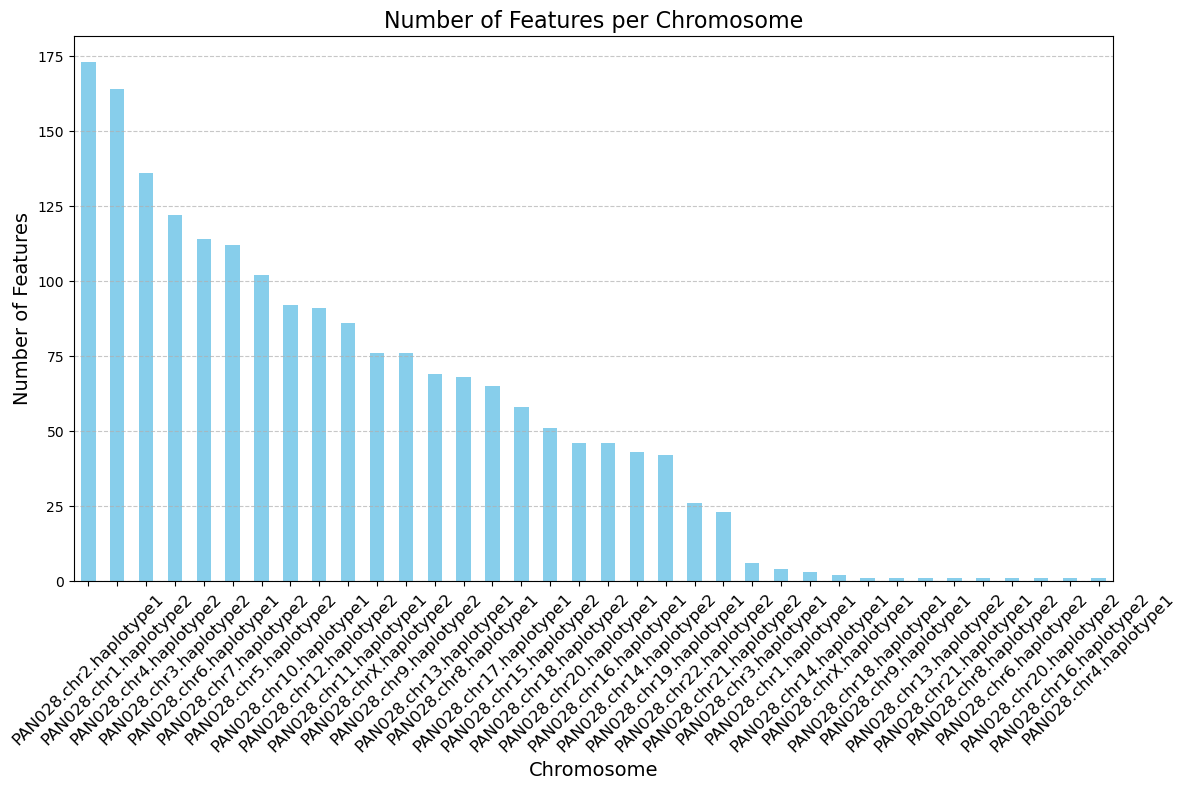

In [17]:
# Count the number of features per chromosome
feature_counts = feature_df['chr'].value_counts()

# Bar plot of the number of features per chromosome
plt.figure(figsize=(12, 8))
feature_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Features per Chromosome', fontsize=16)
plt.xlabel('Chromosome', fontsize=14)
plt.ylabel('Number of Features', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


find gaps in shared contigs coverage
```bash
awk '{print $1"\t0\t"$2}' data/assembly.v1.0.PAN028.diploid-002.fa.fai > data/PAN028_whole_chr.bed
sort -k1,1 -k2,2n data/PAN028_shared_contigs.bed > data/PAN028_shared_contigs.sorted.bed
bedtools subtract -a data/PAN028_whole_chr.bed -b data/PAN028_shared_contigs.sorted.bed > data/PAN028_gaps.bed
cut -f1,2 data/assembly.v1.0.PAN028.diploid-002.fa.fai > data/PAN028_chr.sizes
```

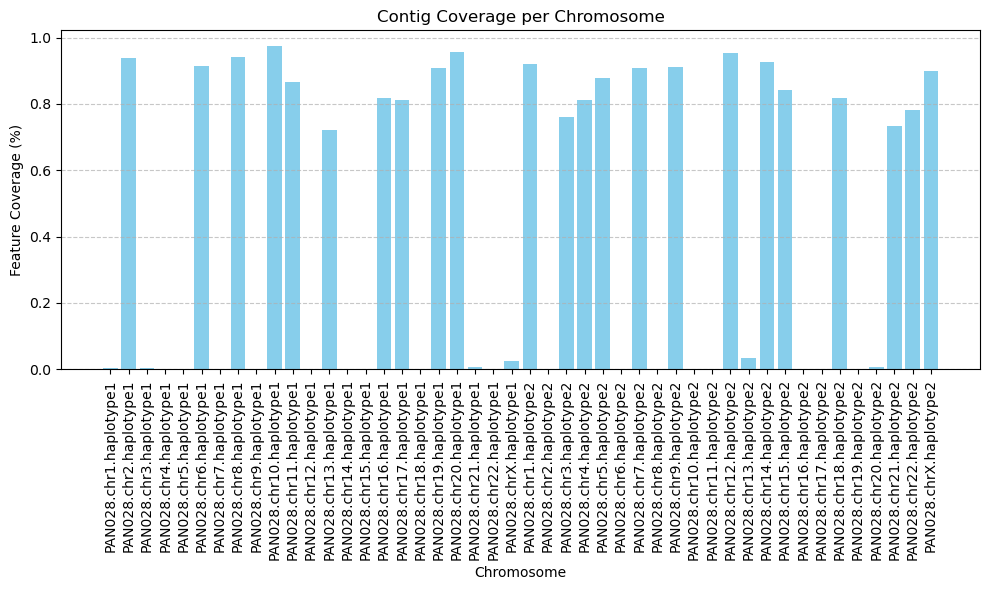

In [32]:
# visualize coverage
gaps="/media/kratka/DATA1/PV269/projekt/data/PAN028_gaps.bed"
whole_chr="/media/kratka/DATA1/PV269/projekt/data/PAN028_whole_chr.bed"

# Load the gaps and whole chromosome BED files as BedTool objects
gaps_bed = pybedtools.BedTool(gaps)
whole_chr_bed = pybedtools.BedTool(whole_chr)

# Calculate the total length of gaps per chromosome
gaps_coverage = {}
for chrom in whole_chr_bed:
    chrom_name = chrom.chrom
    chrom_length = int(chrom.end)
    gaps_in_chrom = gaps_bed.filter(lambda x: x.chrom == chrom_name)
    total_gap_length = sum([int(gap.end) - int(gap.start) for gap in gaps_in_chrom])
    gaps_coverage[chrom_name] = total_gap_length / chrom_length

# Calculate feature coverage (1 - gap coverage) per chromosome
feature_coverage = {chrom: 1 - gap for chrom, gap in gaps_coverage.items()}

# Bar plot of feature coverage per chromosome
plt.figure(figsize=(10, 6))
plt.bar(feature_coverage.keys(), feature_coverage.values(), color='skyblue')
plt.title('Contig Coverage per Chromosome')
plt.xlabel('Chromosome')
plt.ylabel('Feature Coverage (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [35]:
# Filter chromosomes with gaps coverage less than 0.5
filtered_chromosomes = [chrom for chrom, gap_coverage in gaps_coverage.items() if gap_coverage < 0.5]

# Filter the gaps BED file to only include intervals from the filtered chromosomes
filtered_gaps = gaps_bed.filter(lambda x: x.chrom in filtered_chromosomes)

# Filter gaps to only include intervals with a length smaller than gap_size_limit
small_gaps = filtered_gaps.filter(lambda x: int(x.end) - int(x.start) < gap_size_limit)

# Write the filtered gaps to a new BED file
small_gaps.saveas("data/PAN028_filtered_gaps.bed")


<BedTool(data/PAN028_filtered_gaps.bed)>

find transposons overlapping with gaps
```bash
bedtools intersect -a data/assembly.v1.0.PAN028.diploid.RM.bed -b data/PAN028_filtered_gaps.bed -u > repeats_in_gaps.bed
bedtools intersect -a data/PAN028_filtered_gaps.bed -b data/assembly.v1.0.PAN028.diploid.RM.bed -c > data/PAN028_gaps_with_repeat_counts.bed
```

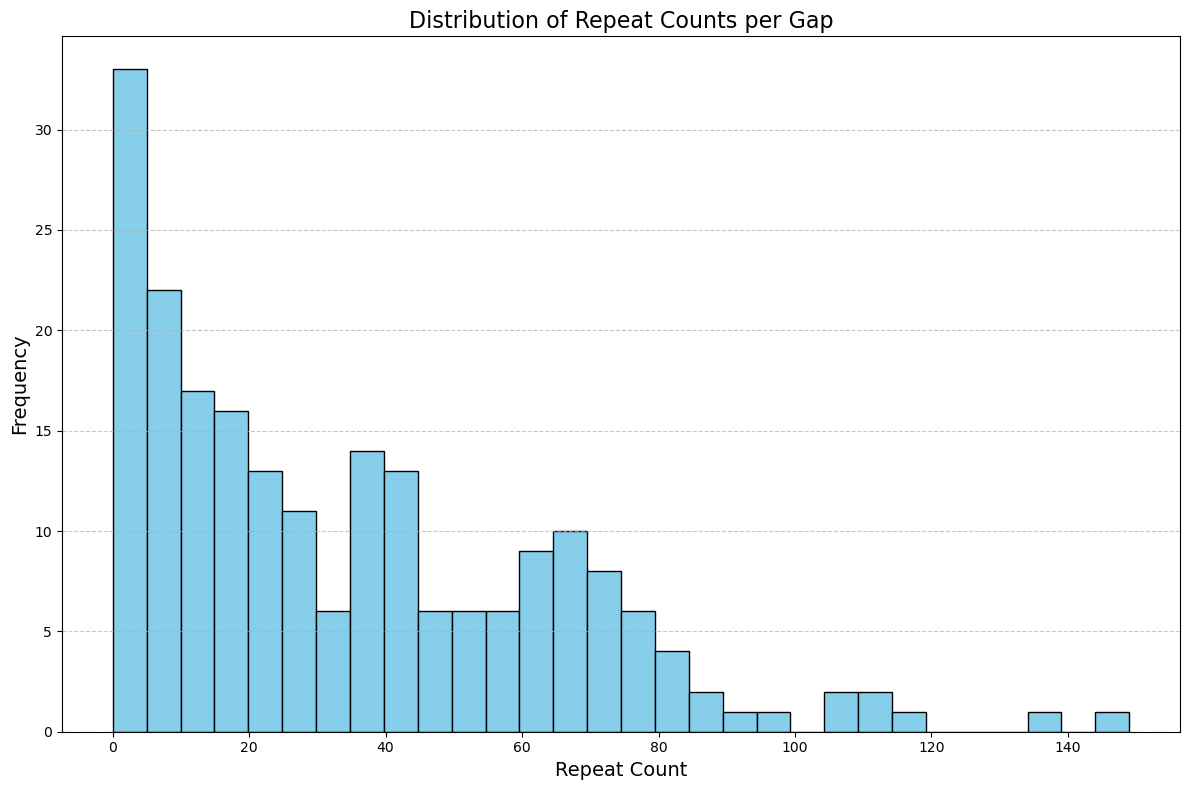

In [ ]:
repeat_counts_path = "data/PAN028_gaps_with_repeat_counts.bed"
gaps_with_repeat_counts = pd.read_csv(repeat_counts_path, sep="\t", header=None)

# Histogram of repeat counts per gap
plt.figure(figsize=(12, 8))
plt.hist(gaps_with_repeat_counts["repeat_count"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Repeat Counts per Gap", fontsize=16)
plt.xlabel("Repeat Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


find gaps that are more than 50% covered by repeats of one family
```bash
awk '{OFS="\t"; print $0, "gap"NR}' data/PAN028_filtered_gaps.bed > data/PAN028_gaps_with_ids.bed
bedtools intersect -a data/PAN028_gaps_with_ids.bed -b data/assembly.v1.0.PAN028.diploid.RM.bed -wa -wb > data/PAN028_gap_repeat_detailed.txt
```

In [ ]:
column_names = ["chr", "gap_start", "gap_end", "gap_ID", "chr_rep", "rep_start", "rep_end", "rep_ID", "rep_length", "strand", "rep_type", "rep_family", "score", "rep_index"]
path_instrasect="data/PAN028_gap_repeat_detailed.txt"
df_intersect = pd.read_csv(path_instrasect, sep="\t", header=None, names=column_names)

# Calculate overlap length for each intersected region
df_intersect["overlap_length"] = df_intersect[["gap_start", "gap_end", "rep_start", "rep_end"]].apply(
    lambda row: max(0, min(row["gap_end"], row["rep_end"]) - max(row["gap_start"], row["rep_start"])),
    axis=1
)

# Filter out rows with overlap less than 80 % of the repeat length
df_intersect = df_intersect[df_intersect["overlap_length"] > 0.8 * df_intersect["rep_length"]]


# Calculate total gap length
df_intersect["gap_length"] = df_intersect["gap_end"] - df_intersect["gap_start"]


# Group by gap_ID and repeat family to get summed overlap per family
df_grouped = (
    df_intersect
    .groupby(["gap_ID", "rep_type", "rep_family", "strand", "chr", "gap_start", "gap_end", "gap_length"])
    .agg({"overlap_length": "sum"})
    .reset_index()
)

# Calculate fraction of gap covered by each repeat family
df_grouped["fraction_of_gap"] = df_grouped["overlap_length"] / df_grouped["gap_length"]

# Filter: repeat families that cover more than 50% of the gap
df_major_families = df_grouped[df_grouped["fraction_of_gap"] > 0.5]

# Optional: sort and view
df_major_families = df_major_families.sort_values(["gap_ID", "fraction_of_gap"], ascending=[True, False])

# Save result
df_major_families.to_csv("data/PAN028_repeats_covering_50pct_of_gaps.tsv", sep="\t", index=False)


In [47]:
# export bed
df_major_families_bed = df_major_families[["chr", "gap_start", "gap_end", "gap_ID", "rep_type", "rep_family", "fraction_of_gap"]]

path = "data/PAN028_repeats_covering_50pct_of_gaps.bed"
df_major_families_bed.to_csv(path, sep="\t", header=False, index=False)

# Looking at repeatmasker annotations within each block

In [ ]:
RM_colnames = ["chr", "start", "end", "ID", "score", "strand", "rep_type", "rep_family", "rep_score", "rep_index"]
df_grandmother_RM = pd.read_csv(path_grandmother_RM, sep="\t", header=None, names=RM_colnames)
df_mother_RM = pd.read_csv(path_mother_RM, sep="\t", header=None, names=RM_colnames)
df_grandfather_RM = pd.read_csv(path_grandfather_RM, sep="\t", header=None, names=RM_colnames)
df_proband_RM = pd.read_csv(path_proband_RM, sep="\t", header=None, names=RM_colnames)



In [ ]:
for row in df_maternal.iterrows():
    grandparent_info = split_info(row[1]["PAN010_info"])
    mother_info = split_info(row[1]["PAN027_info"])
    proband_info = split_info(row[1]["PAN028_info"])
    print(f"Grandparent: {grandparent_info[0]}:{grandparent_info[1]}-{grandparent_info[2]}")

    grandmother_contig_repeats = df_grandmother_RM[
        (df_grandmother_RM["chr"] == grandparent_info[0]) &
        (df_grandmother_RM["start"] >= grandparent_info[1]) &
        (df_grandmother_RM["end"] <= grandparent_info[2])
    ]
    mother_contig_repeats = df_mother_RM[
        (df_mother_RM["chr"] == mother_info[0]) &
        (df_mother_RM["start"] >= mother_info[1]) &
        (df_mother_RM["end"] <= mother_info[2])
    ]
    proband_contig_repeats = df_proband_RM[
        (df_proband_RM["chr"] == proband_info[0]) &
        (df_proband_RM["start"] >= proband_info[1]) &
        (df_proband_RM["end"] <= proband_info[2])
    ]
    print(f"Grandmother repeats: {len(grandmother_contig_repeats)}")